In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm

In [2]:
DATA_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'
ATTRS_PATH = 'data/attr.csv'
FIGSIZE = (16, 7)

In [3]:
sns.set()
tqdm.pandas()

pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Чтение данных

In [4]:
df = pd.read_csv(DATA_PATH
                #  , nrows=30000000
)
df.head()

,ego_id,u,v,t,x1,x2,x3
0,0,131,84,148.00000,0.00000,0.00000,0.00000
1,0,135,164,396.70000,0.06246,0.00000,0.00000
2,0,47,15,NaN,0.00000,0.00000,1.00000
3,0,5,4,594.50000,0.04963,0.00000,0.00000
4,0,176,219,45.50000,1.23794,0.00000,0.00000


In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122280372 entries, 0 to 122280371
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ego_id  int64  
 1   u       int64  
 2   v       int64  
 3   t       float64
 4   x1      float64
 5   x2      float64
 6   x3      float64
dtypes: float64(4), int64(3)
memory usage: 6.4 GB


```ego_id``` - id эго-графа

```u``` - пользователь 1, если u = 0, это центр одуванчика

```v``` - пользователь 2

```t``` -  целое число дней, прошедшее с возникновения дружбы между
каждой парой пользователей  

```x1``` - коэфф 1 (таргет)

```x2``` - коэфф 2

```x3``` - коэфф 3

# Распределения данных

In [6]:
df.describe()

,ego_id,u,v,t,x1,x2,x3
count,122280372.00000,122280372.00000,122280372.00000,103563154.00000,122280372.00000,122280372.00000,122280372.00000
mean,850887205962.44507,87.66378,94.80200,114.01289,0.69098,0.19868,0.15264
std,495831201020.52600,69.90831,73.97358,112.57239,1.35416,0.78438,0.35964
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,420906795337.00000,30.00000,34.00000,27.60000,0.00001,0.00000,0.00000
50%,850403524886.00000,73.00000,79.00000,81.10000,0.07433,0.00000,0.00000
75%,1279900254705.00000,133.00000,143.00000,161.10000,0.89606,0.00000,0.00000
max,1709396984692.00000,299.00000,299.00000,594.50000,47.28715,10.74882,1.00000


У x1 странное максимальное значение, возможно данные обновят

In [7]:
df.isna().sum() / df.shape[0] * 100

ego_id    0.00000
u         0.00000
v         0.00000
t        15.30680
x1        0.00000
x2        0.00000
x3        0.00000
dtype: float64

Для 15% ребер время неизвестно (NaN). Скорее всего, это те самые пары пользователей, которые не подружились

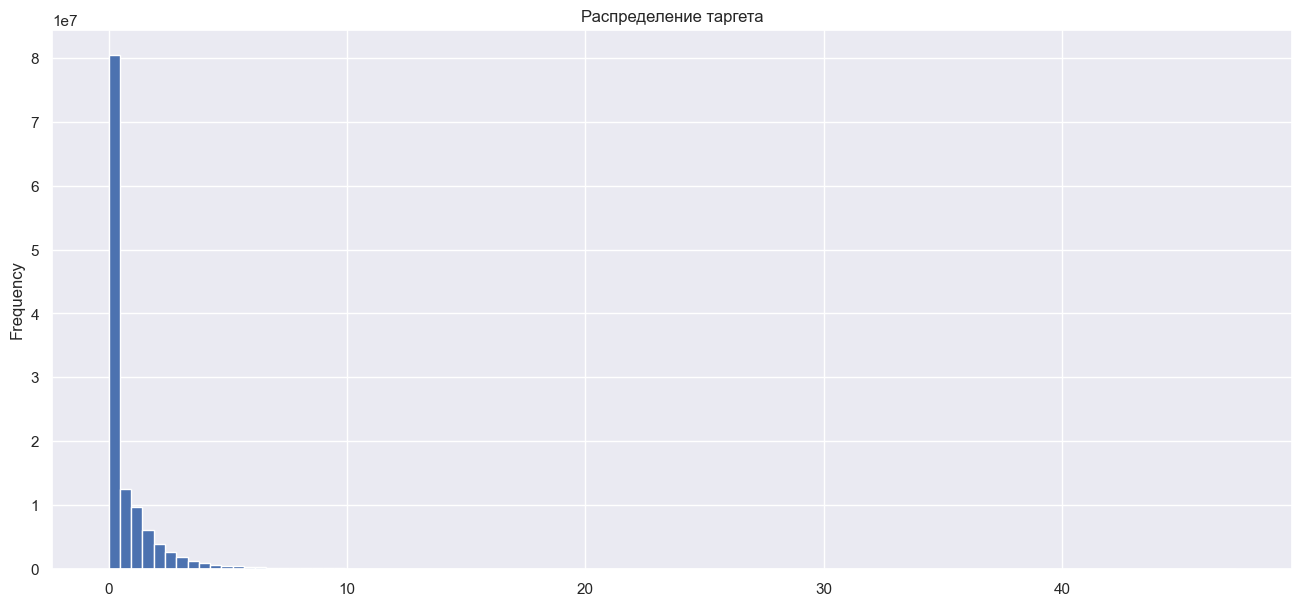

In [8]:
plt.figure(figsize=FIGSIZE);
df['x1'].plot(kind='hist', bins=100, title='Распределение таргета');

In [9]:
df['x1'].describe()

count   122280372.00000
mean            0.69098
std             1.35416
min             0.00000
25%             0.00001
50%             0.07433
75%             0.89606
max            47.28715
Name: x1, dtype: float64

Видим, что для 50% квартиля значения таргета не превышают 0.1. Такие смещения могут быть из-за максимального значения 47, но можно предположить, что большая часть пар пользователей мало взаимодействует друг с другом. 

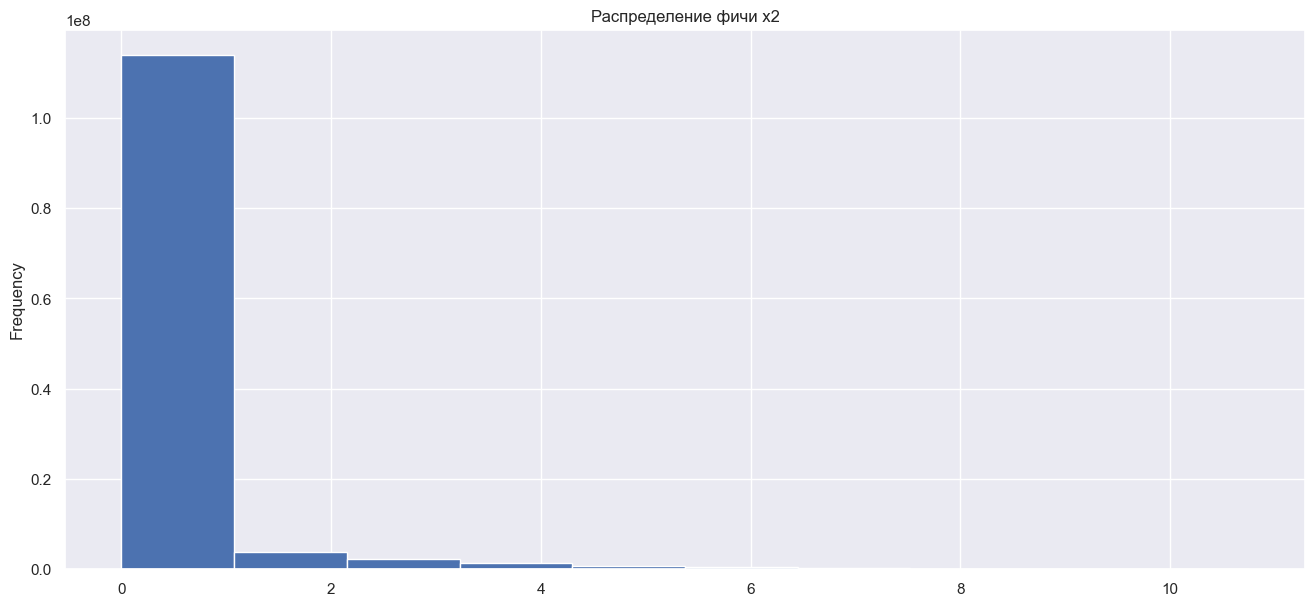

In [10]:
plt.figure(figsize=FIGSIZE);
df['x2'].plot(kind='hist', bins=10, title='Распределение фичи x2');

75% квартиль: все значения равны 0

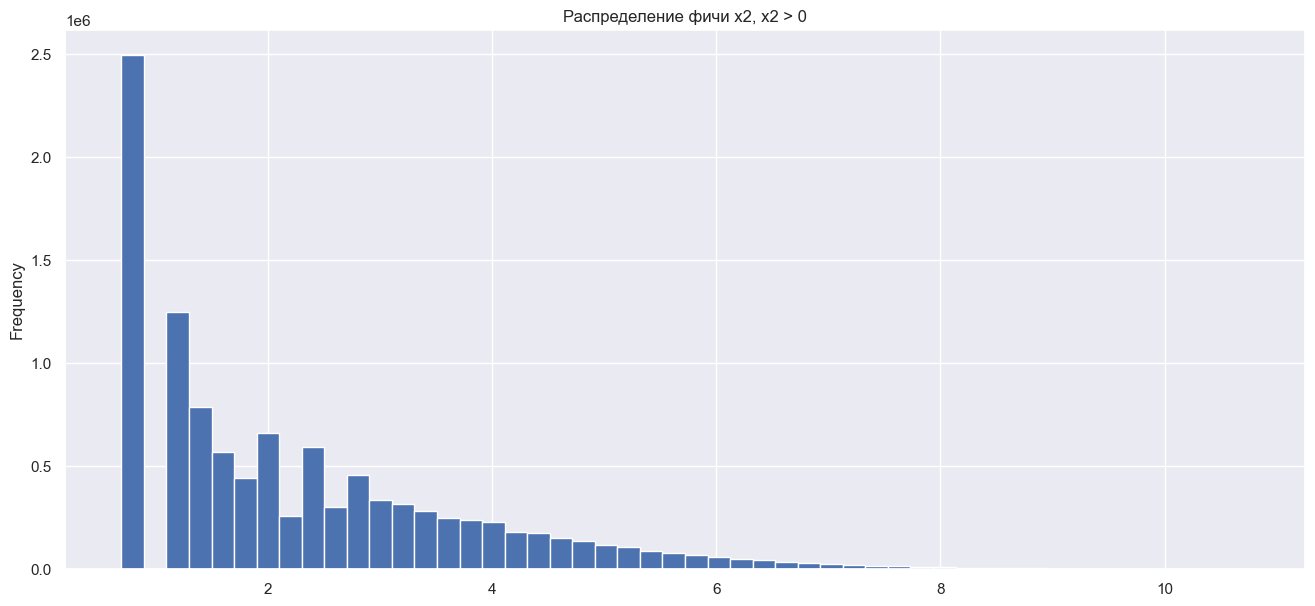

In [11]:
plt.figure(figsize=FIGSIZE);
df[df['x2'] > 0]['x2'].plot(kind='hist', bins=50, title='Распределение фичи x2, x2 > 0');

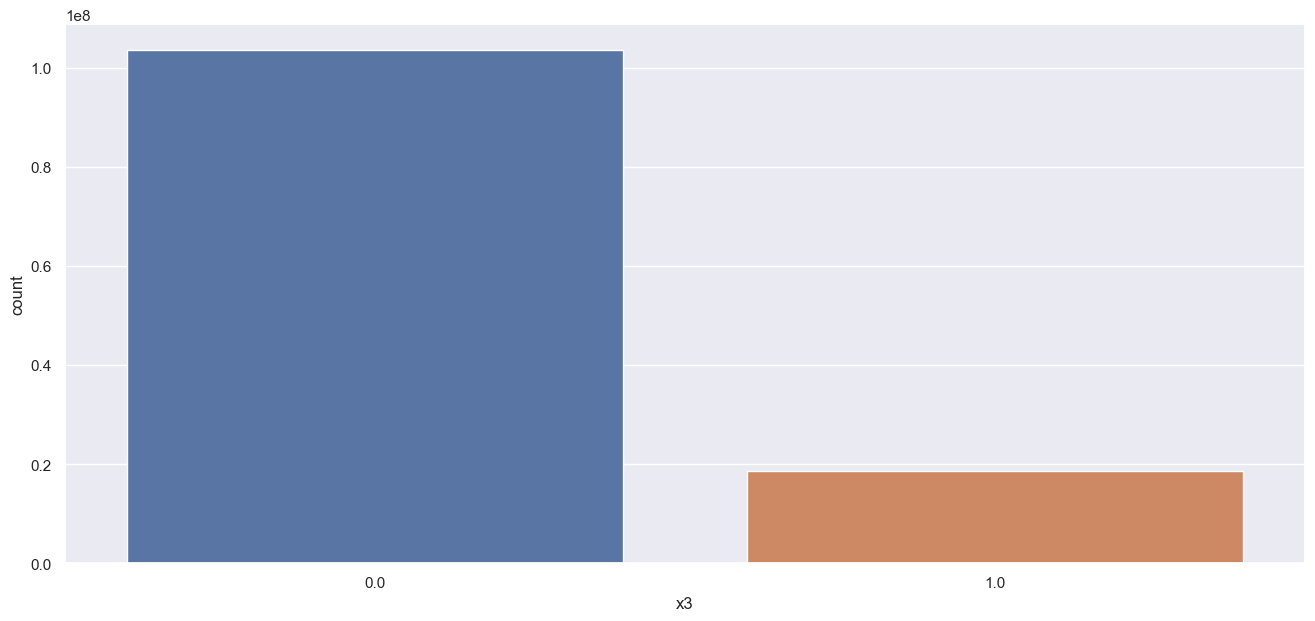

In [12]:
plt.figure(figsize=FIGSIZE);
sns.countplot(x='x3', data=df);

Фича принимает только 2 значения. Преимущественно равна 0. Согласуется с гипотезой о том, что большая часть пар пользователей не взаимодействуют между собой

In [13]:
df['t'].isna().sum() / df.shape[0]

0.15306804922052414

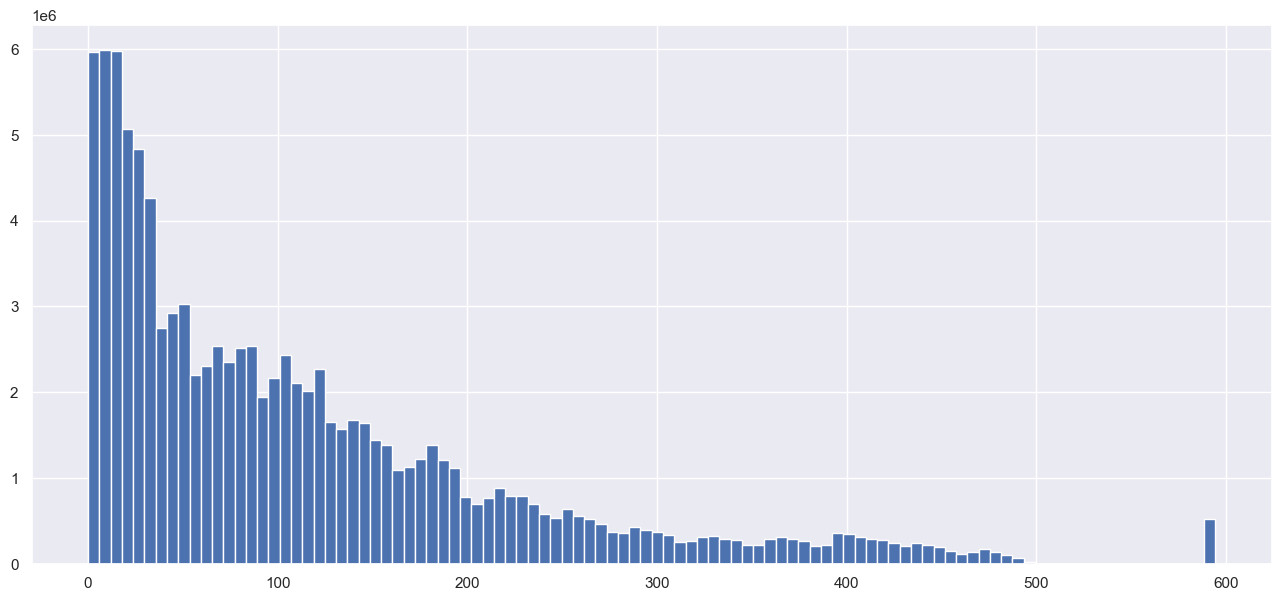

In [14]:
plt.figure(figsize=FIGSIZE);
df['t'].hist(bins=100);

In [ ]:
plt.figure(figsize=FIGSIZE);
df.boxplot(column=['t']);

Распределение времени с тяжелым хвостом. Справа, около 600, наблюдаются выбросы

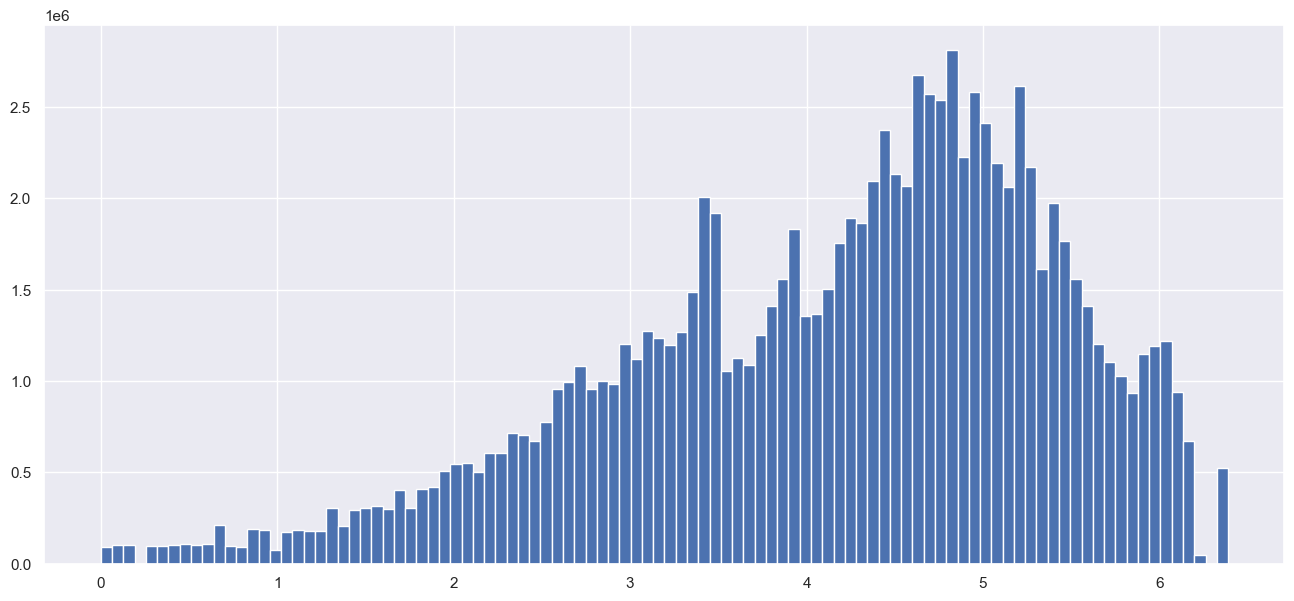

In [15]:
plt.figure(figsize=FIGSIZE);
df['t'].apply(lambda x: np.log(x + 1)).hist(bins=100);  # логарифмируем + 1, чтобы избавиться от 0

# Анализ графов

In [16]:
counts = df.groupby(['ego_id', 'u'])['v'].agg(['count'])
counts

count
ego_id        u        
0             0     193
              2       4
              4      10
              5      24
              6       3
...                 ...
1709396984692 12      3
              14      4
              15      5
              16      5
              18      1

[11484521 rows x 1 columns]

In [17]:
centers = counts.loc[0]  # получаем центры графов 
centers.max()

count    193
dtype: int64

Среднее значение времени для центра графа, чтобы завести друзей

In [18]:
time = df.groupby(['ego_id', 'u'])['t']
time.mean().loc[0]

u
0     212.25812
2     594.50000
4     441.94000
5     386.39583
6     413.93333
         ...   
287    38.40000
288    94.30000
290    15.00000
292   126.50000
297   126.50000
Name: t, Length: 272, dtype: float64

Медианное значение времени для центра графа, чтобы завести друзей

In [19]:
time.median().loc[0]

u
0     149.20000
2     594.50000
4     509.40000
5     404.60000
6     594.50000
         ...   
287    38.40000
288    94.30000
290    15.00000
292   126.50000
297   126.50000
Name: t, Length: 272, dtype: float64

# Attributes

In [20]:
attrs = pd.read_csv(ATTRS_PATH)
attrs.head()

,ego_id,u,age,city_id,sex,school,university
0,0,227,68,-1,1,778293348,-1
1,0,45,38,237065842,1,82803468,238500268
2,0,142,60,237065842,1,196560139,-1
3,0,280,66,-1,2,963209731,720783270
4,0,41,18,-1,2,308862409,-1


In [21]:
attrs_ego_id = set(attrs['ego_id'].unique())
df_ego_id = set(df['ego_id'].unique())

len(df_ego_id.difference(attrs_ego_id))

0

Все пользователи u присутствуют в attrs 

In [22]:
(attrs == -1).sum() / attrs.shape[0] * 100

ego_id        0.00000
u             0.00000
age           0.69206
city_id      35.64787
sex           0.03747
school       59.56195
university   72.13572
dtype: float64

Получили % NaN-значений

In [23]:
attrs = attrs.replace({-1: np.NaN})

In [24]:
attrs.isna().sum() / attrs.shape[0] * 100

ego_id        0.00000
u             0.00000
age           0.69206
city_id      35.64787
sex           0.03747
school       59.56195
university   72.13572
dtype: float64

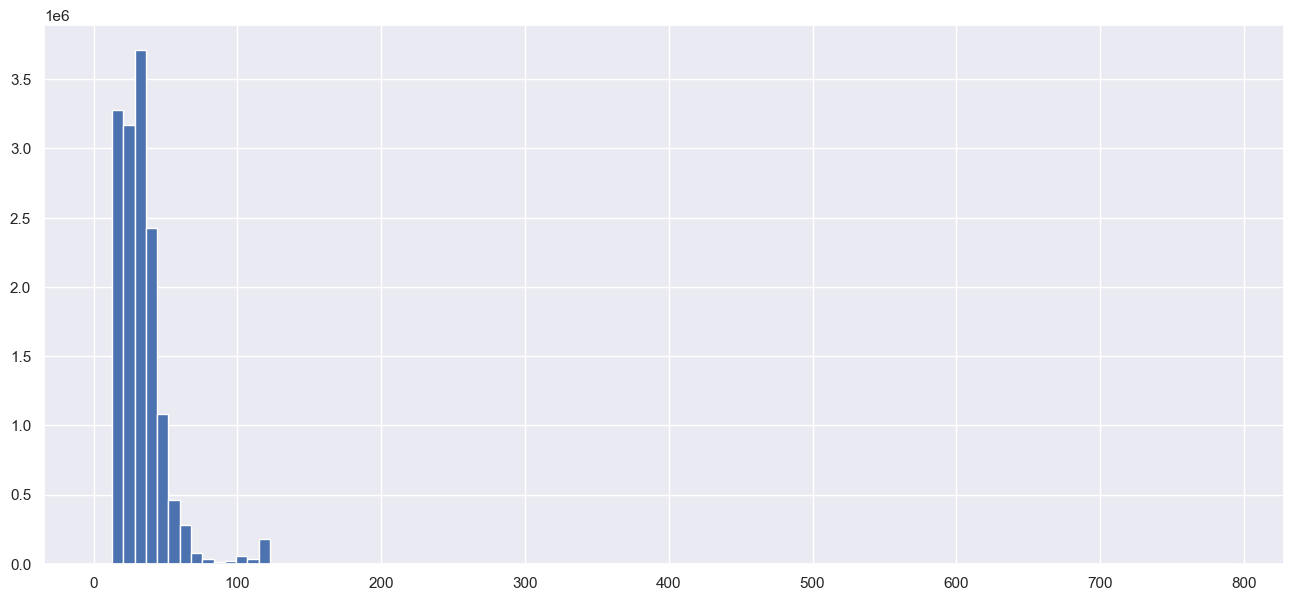

In [25]:
plt.figure(figsize=FIGSIZE);
attrs['age'].hist(bins=100);

In [26]:
attrs['age'].describe()

count   14827418.00000
mean          32.98017
std           16.61879
min            5.00000
25%           22.00000
50%           31.00000
75%           39.00000
max          789.00000
Name: age, dtype: float64

Пользователи - преимущественно молодые люди

In [27]:
attrs['city_id'].nunique()

1791317

In [28]:
attrs.groupby(['ego_id', 'city_id']).nunique().loc[0, 'u']

city_id
16261135.00000       1
89878857.00000       2
91132085.00000       1
122329603.00000      3
151639620.00000      1
200057624.00000      1
237065842.00000    159
238321946.00000     22
257307113.00000      1
298413605.00000     12
311391434.00000      1
358692542.00000      1
398568811.00000      1
455967165.00000      1
505098895.00000      1
515825832.00000     16
529466071.00000      1
583984465.00000      1
637930249.00000      1
720792568.00000      1
852260251.00000      1
868585793.00000      1
884041880.00000      3
941820163.00000      1
979159080.00000      1
Name: u, dtype: int64

Несколько групп пользователей-центров нод, которые живут в одном городе

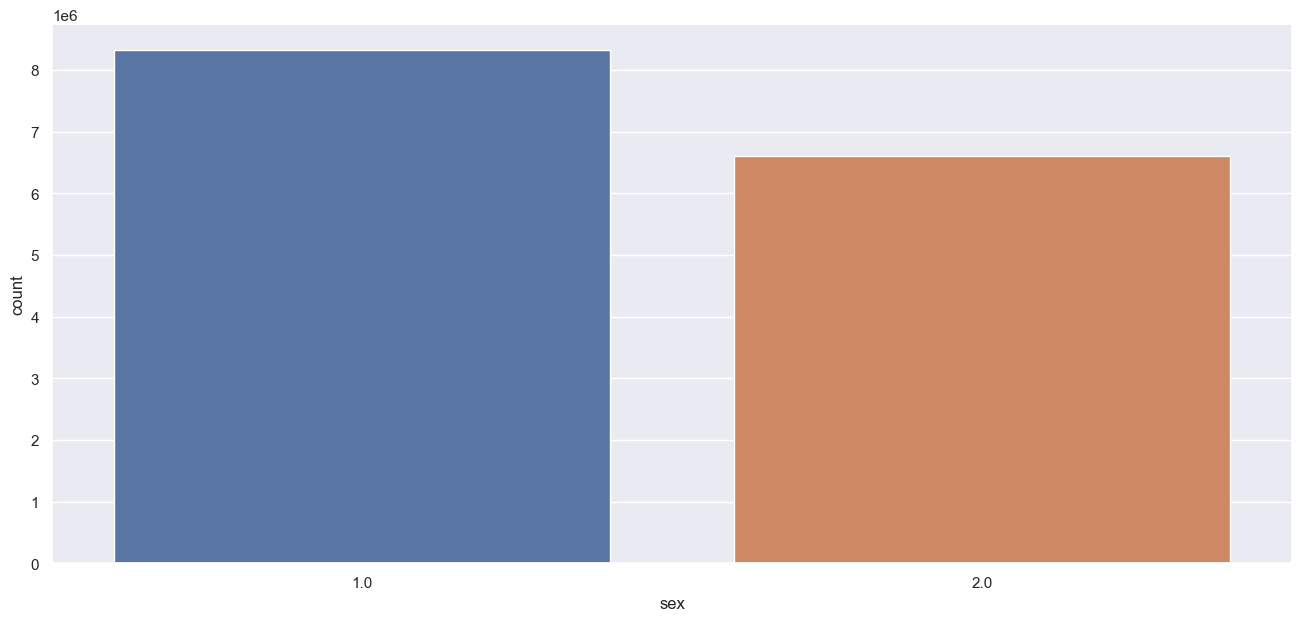

In [29]:
plt.figure(figsize=FIGSIZE);
sns.countplot(x='sex', data=attrs);

Незначительный перевес пола 1, пользователи в датасете относительно сбалансированы

In [30]:
same_school = attrs.groupby(['ego_id', 'school']).nunique().loc[0, 'u']  # 
same_school

school
2552673.00000      1
7900518.00000      1
9694743.00000      1
12969477.00000     1
17463303.00000     1
                  ..
982829159.00000    1
986417317.00000    1
994112604.00000    3
996782138.00000    1
997337003.00000    1
Name: u, Length: 146, dtype: int64

Пользователи, которые учились в одной школе

In [31]:
same_university = attrs.groupby(['ego_id', 'university']).nunique().loc[0, 'u']
same_university

university
15325483.00000      1
53276069.00000      1
61912051.00000      1
62501167.00000      2
66999397.00000      5
                   ..
937129023.00000     1
946539133.00000     1
953410497.00000     1
954988066.00000     1
991369526.00000    19
Name: u, Length: 85, dtype: int64

Пользователи, которые учились в одном университете

In [32]:
city_info = attrs.groupby(['city_id'])
city_info.count()['school']

city_id
759.00000          1
1179.00000         0
1324.00000         2
3099.00000         0
3343.00000         0
                  ..
999999134.00000    2
999999390.00000    0
999999531.00000    1
999999708.00000    1
999999976.00000    0
Name: school, Length: 1791317, dtype: int64

Посчитали, сколько школ в каждом городе (из того что нам известно)

In [33]:
city_info.count()['university']

city_id
759.00000          0
1179.00000         0
1324.00000         3
3099.00000         0
3343.00000         0
                  ..
999999134.00000    2
999999390.00000    0
999999531.00000    0
999999708.00000    0
999999976.00000    0
Name: university, Length: 1791317, dtype: int64

Аналогично с университетами

In [34]:
university_after_school = attrs.groupby('school').count()['university']
university_after_school

school
392.00000          1
968.00000          1
990.00000          0
1504.00000         1
1792.00000         2
                  ..
999999079.00000    0
999999428.00000    0
999999620.00000    1
999999823.00000    1
999999969.00000    1
Name: university, Length: 3743611, dtype: int64

Пользователи, которые учились в одной школе, поступали в N разных университетов

In [35]:
university_after_school.describe()

count   3743611.00000
mean          0.71565
std           1.21684
min           0.00000
25%           0.00000
50%           1.00000
75%           1.00000
max          82.00000
Name: university, dtype: float64

In [36]:
university_after_school[university_after_school == university_after_school.max()]

school
189635454.00000    82
487308878.00000    82
Name: university, dtype: int64

Супер-школы